In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
# from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

c:\Users\lnhna\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [35]:
categories = ['begin', 'malignants', 'normal']

In [36]:
directory = 'D://PROJECT-AI-231//Data//data//The IQ-OTHNCCD lung cancer dataset'


In [19]:
os.getcwd()

'd:\\PROJECT-AI-231'

In [32]:
os.listdir("D://PROJECT-AI-231//Data//data//The IQ-OTHNCCD lung cancer dataset")

['begin', 'IQ-OTH_NCCD lung cancer dataset.txt', 'malignants', 'normal']

In [37]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'begin': {'512 x 512': 120},
 'malignants': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'normal': {'512 x 512': 415, '331 x 506': 1}}

begin


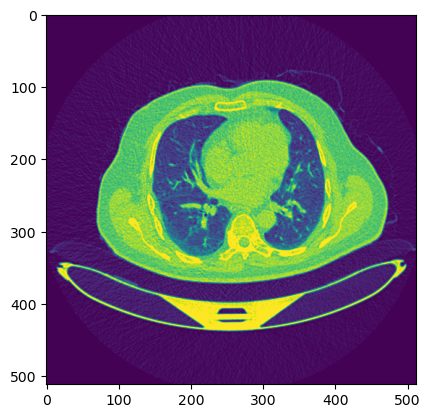

malignants


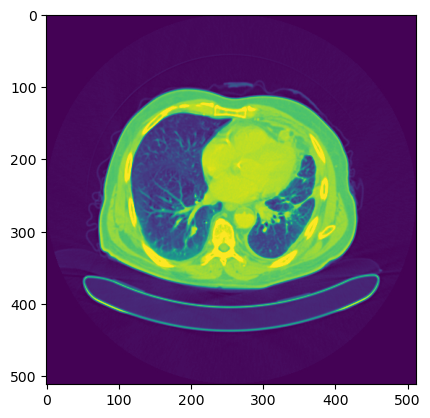

normal


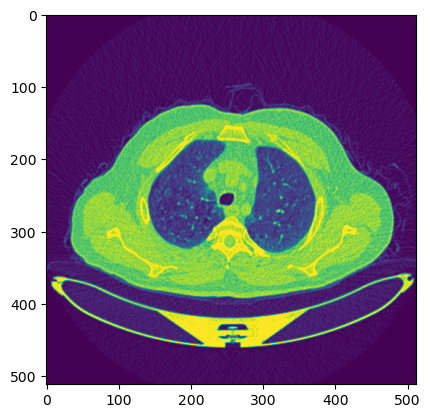

In [38]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

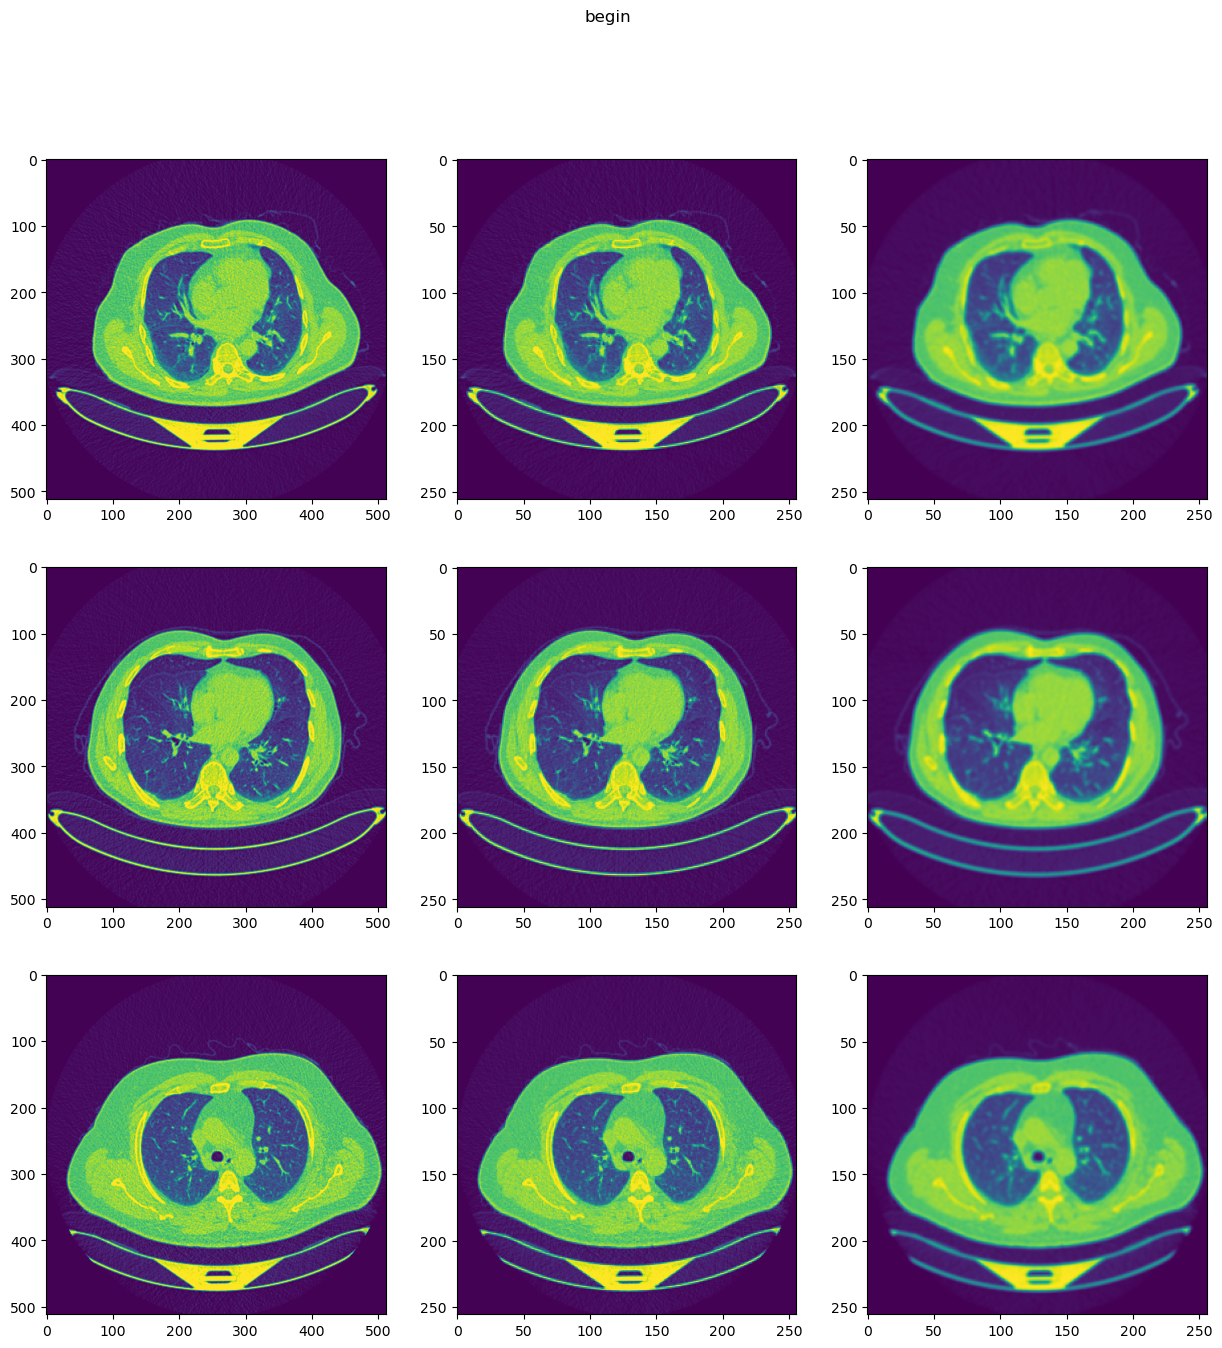

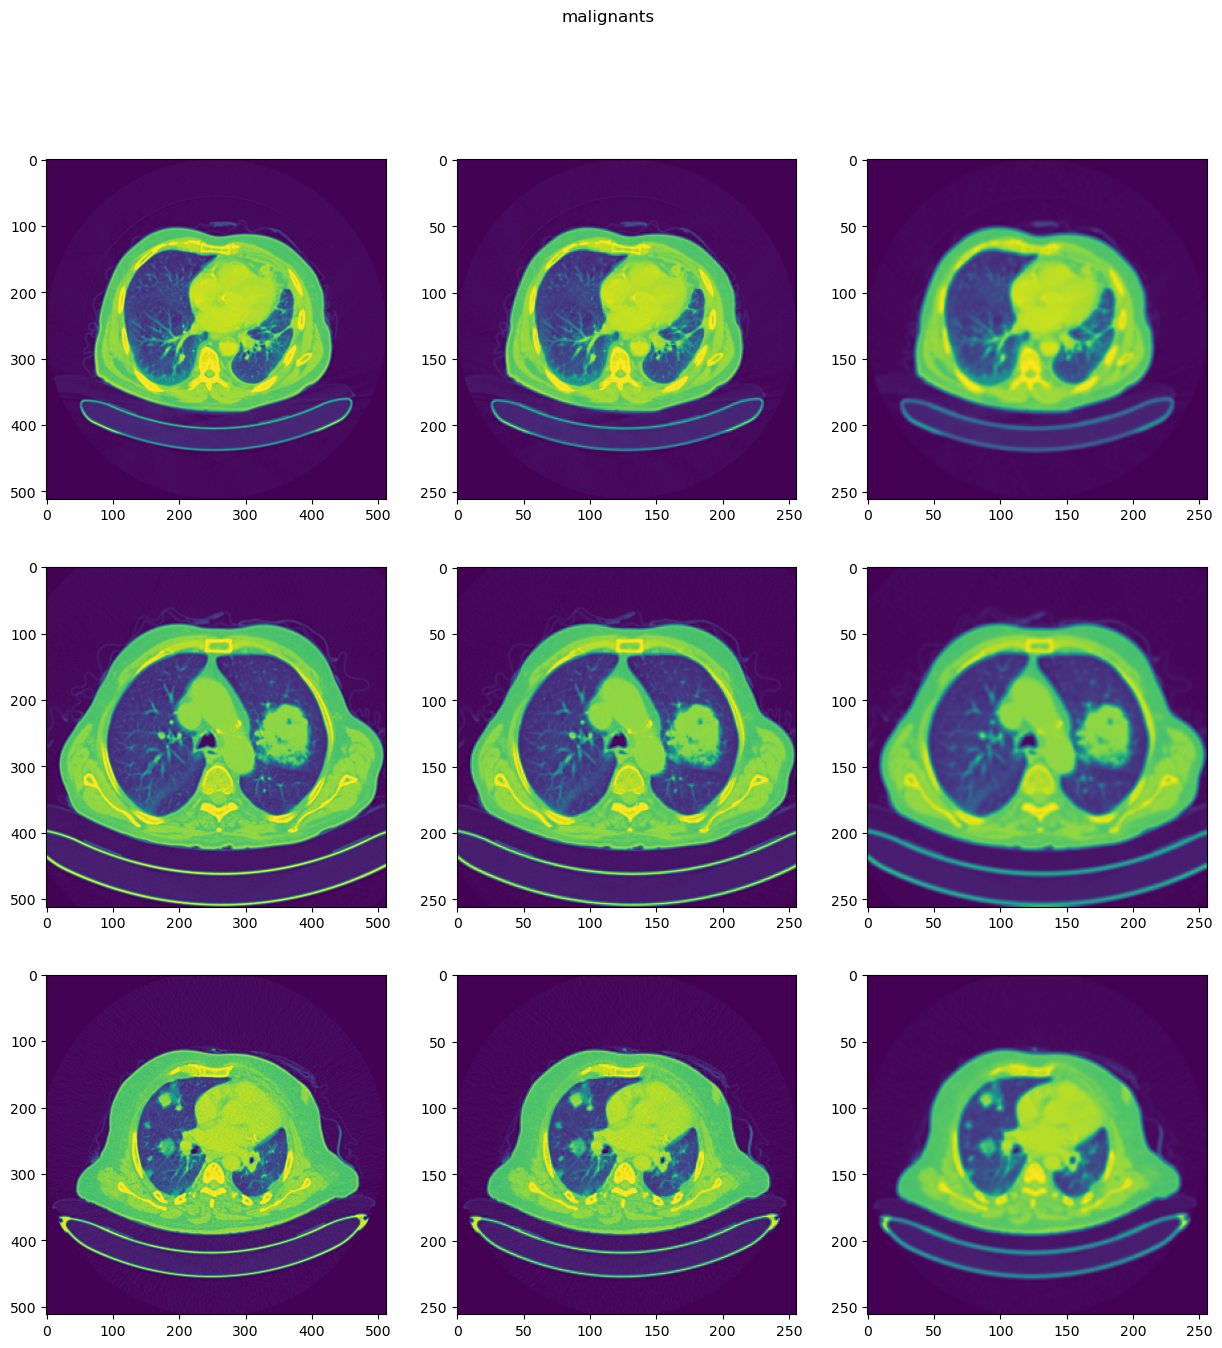

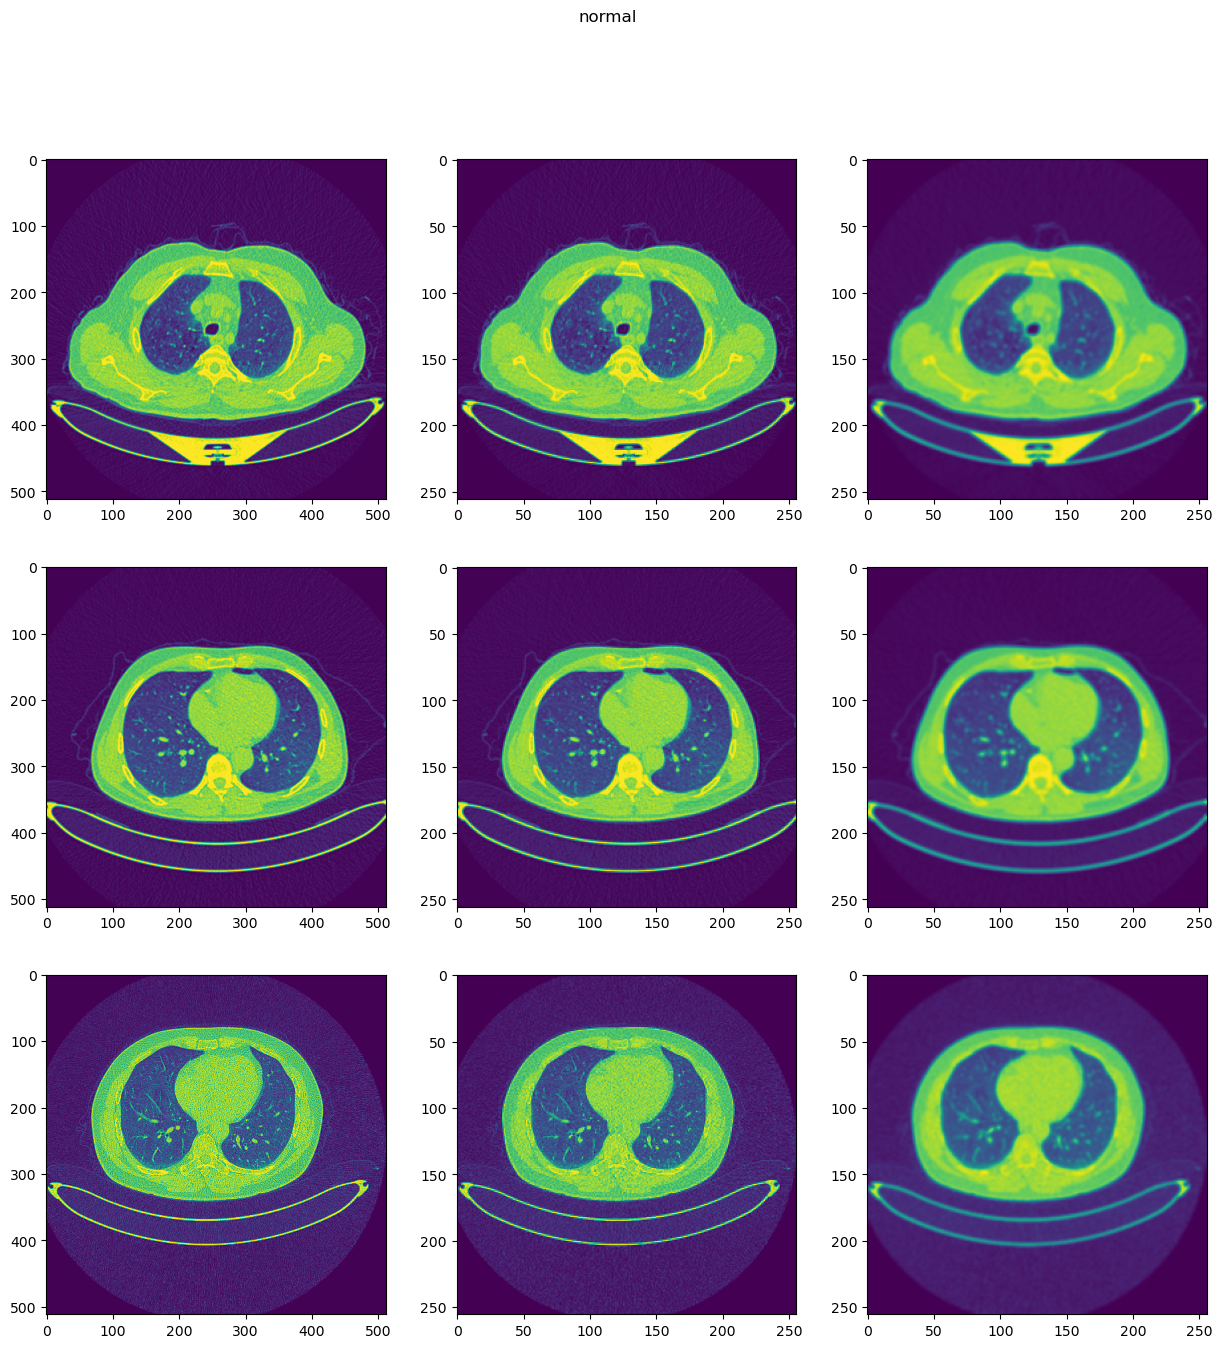

In [39]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

In [40]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


In [42]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [43]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

In [44]:
resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(resnet_base)

# Added custom classification layers on top
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40359171 (153.96 MB)
Trainable params: 16777731 (64.00 MB)
Non-trainable params: 23581440 (89.96 MB)
_________________________________________________________________


In [45]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [46]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
103/103 [==============================] - 212s 2s/step - loss: 0.9604 - accuracy: 0.5985 - val_loss: 0.7509 - val_accuracy: 0.7273
Epoch 2/20
103/103 [==============================] - 202s 2s/step - loss: 0.6983 - accuracy: 0.7360 - val_loss: 0.6655 - val_accuracy: 0.7709
Epoch 3/20
103/103 [==============================] - 196s 2s/step - loss: 0.6023 - accuracy: 0.7835 - val_loss: 0.5629 - val_accuracy: 0.8036
Epoch 4/20
103/103 [==============================] - 179s 2s/step - loss: 0.5110 - accuracy: 0.8260 - val_loss: 0.4965 - val_accuracy: 0.8218
Epoch 5/20
103/103 [==============================] - 163s 2s/step - loss: 0.4421 - accuracy: 0.8552 - val_loss: 0.4673 - val_accuracy: 0.8255
Epoch 6/20
103/103 [==============================] - 172s 2s/step - loss: 0.3944 - accuracy: 0.8625 - val_loss: 0.3994 - val_accuracy: 0.8327
Epoch 7/20
103/103 [==============================] - 191s 2s/step - loss: 0.3207 - accuracy: 0.8869 - val_loss: 0.3376 - val_accuracy: 0.9200

In [48]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 28s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        35
           1       1.00      0.95      0.97       134
           2       0.88      1.00      0.93       106

    accuracy                           0.95       275
   macro avg       0.96      0.91      0.93       275
weighted avg       0.95      0.95      0.95       275

[[ 27   0   8]
 [  0 127   7]
 [  0   0 106]]


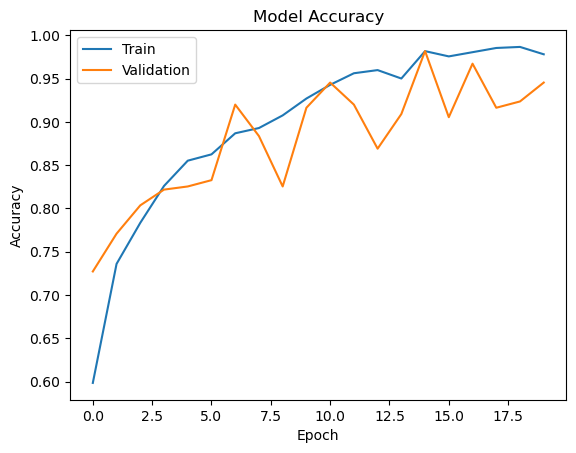

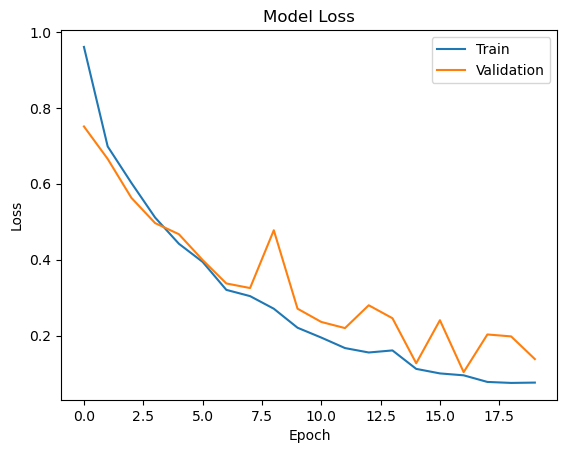

In [49]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()